# StereoVision

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## time
import math
import time

### Check Versionm

In [166]:
# Upgraid
!python -m pip install --upgrade pip

In [2]:
print("opencv version : " + cv2.__version__)
print("numpy version : " + np.__version__)

opencv version : 4.6.0
numpy version : 1.23.3


### Load Image

In [3]:
image_name = ["img/ambush_5_L.jpg",
"img/ambush_5_R.jpg",
"img/arc_L.jpg",
"img/arc_R.jpg",
"img/bike_L.png",
"img/bike_R.png",
"img/toy_L.png",
"img/toy_R.png",
"img/toys_L.png",
"img/toys_R.png",
"img/LL.png",
"img/RR.png"]
print(image_name[0])
print(image_name[7])

img/ambush_5_L.jpg
img/toy_R.png


In [4]:
img = []
for i in image_name:
    img.append(cv2.imread(i,0))

cv2.imshow("TEST",img[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

### StereoBM, StereoSGBM

In [5]:
def StereoBM(imgL,imgR, nD = 16, bS = 15) :
    stereo = cv2.StereoBM_create(nD, bS)
    stereo.setDisp12MaxDiff(25)
    stereo.setUniquenessRatio(15)
    start = time.time()
    disparity = stereo.compute(imgL,imgR)
    end = time.time()
    print(f"{end - start:.5f} sec")
    plt.imshow(disparity,'gray')
    plt.colorbar()
    plt.show()

0.01104 sec


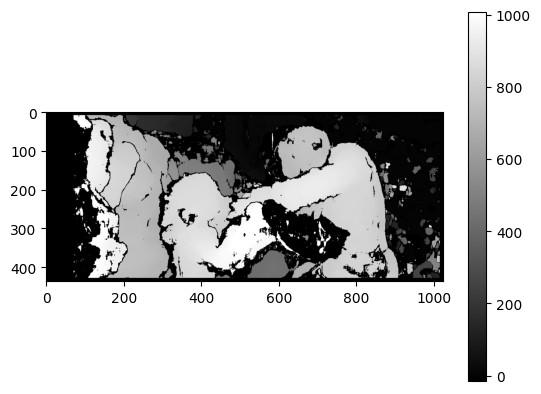

0.01700 sec


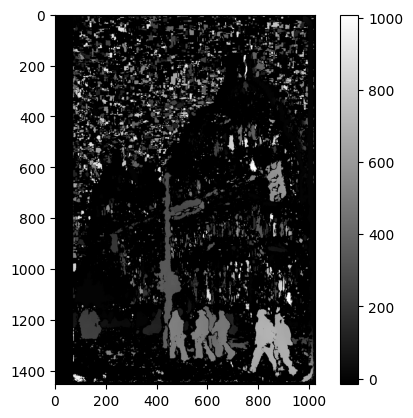

0.08300 sec


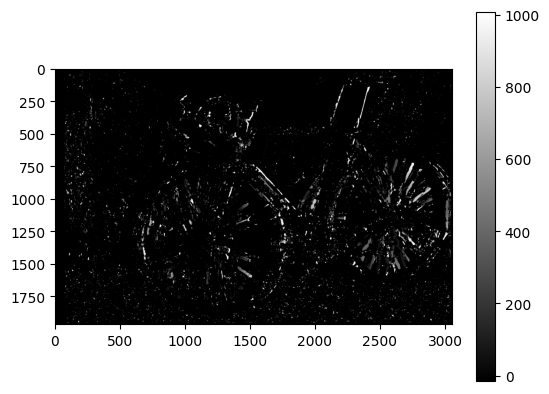

0.00499 sec


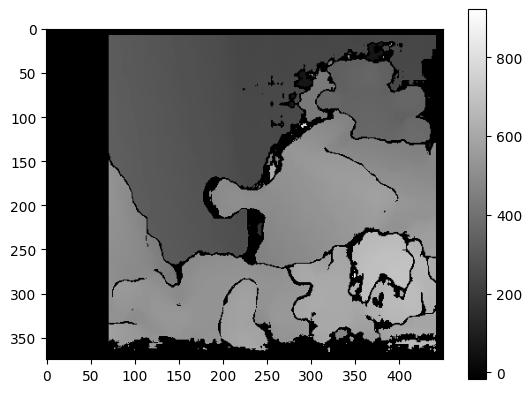

0.00796 sec


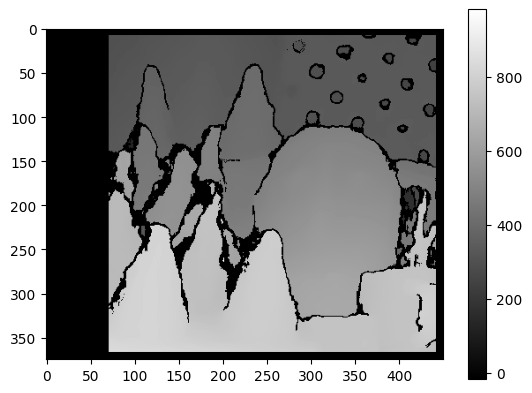

0.00200 sec


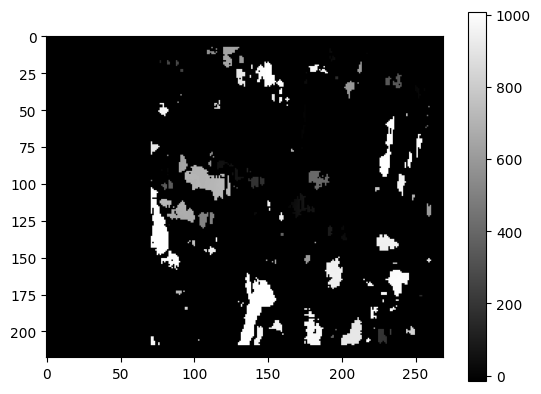

In [7]:
for i in range(0,12,2) :
    StereoBM(img[i], img[i+1], 16*4, 17)

In [233]:
def StereoSGBM(imgL,imgR, nD = 16, bS = 15) :
    stereo = cv2.StereoSGBM_create(
        numDisparities=nD,
        blockSize=bS,
        uniquenessRatio=5,
        speckleWindowSize=5,
        speckleRange=5,
        disp12MaxDiff=25,
        P1=8 * 3 * win_size ** 2,
        P2=32 * 3 * win_size ** 2,
    )
    start = time.time()
    disparity = stereo.compute(imgL,imgR)
    end = time.time()
    print(f"{end - start:.5f} sec")
    plt.imshow(disparity,'gray')
    plt.colorbar()
    plt.show()

0.10172 sec


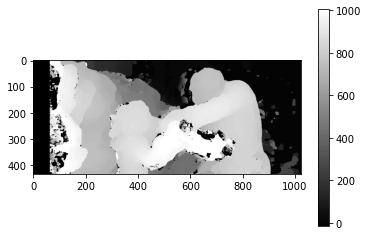

0.33111 sec


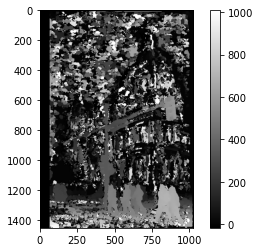

1.59942 sec


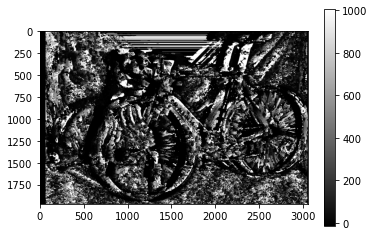

0.03295 sec


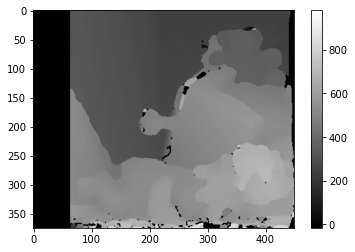

0.03490 sec


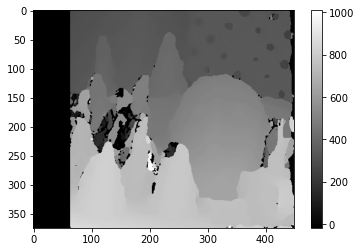

In [234]:
for i in range(0,10,2) :
    StereoSGBM(img[i], img[i+1], 16*4, 17)    


## Census Transform

In [174]:
import numpy as np
import cv2

def transform(image, window_size=3):
    half_window_size = window_size // 2

    image = cv2.copyMakeBorder(image, top=half_window_size, left=half_window_size, right=half_window_size, bottom=half_window_size, borderType=cv2.BORDER_CONSTANT, value=0)
    rows, cols = image.shape
    census = np.zeros((rows - half_window_size * 2, cols - half_window_size * 2), dtype=np.uint8)
    center_pixels = image[half_window_size:rows - half_window_size, half_window_size:cols - half_window_size]

    offsets = [(row, col) for row in range(half_window_size) for col in range(half_window_size) if not row == half_window_size + 1 == col]
    for (row, col) in offsets:
        census = (census << 1) | (image[row:row + rows - half_window_size * 2, col:col + cols - half_window_size * 2] >= center_pixels)
    return census

def column_cost(left_col, right_col):
    return np.sum(np.unpackbits(np.bitwise_xor(left_col, right_col), axis=1), axis=1).reshape(left_col.shape[0], left_col.shape[1])

def cost(left, right, window_size=3, disparity=0):
    ct_left = transform(left, window_size=window_size)
    ct_right = transform(right, window_size=window_size)
    rows, cols = ct_left.shape
    C = np.full(shape=(rows, cols), fill_value=0)
    for col in range(disparity, cols):
        C[:, col] = column_cost(
            ct_left[:, col:col + 1],
            ct_right[:, col - disparity:col - disparity + 1]
        ).reshape(ct_left.shape[0])
    return C

def norm(image):
    return cv2.normalize(image, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)


In [186]:
def Census_Transform (left, right, window_size = 5, ndisp = 7):
    ct_left = norm(transform(left, window_size)) ## Census Transform
    ct_right = norm(transform(right, window_size))

    ct_costs = [] ## Result
    for exponent in range(0, 6):
        import math
        disparity = int(ndisp / math.pow(2, exponent))
        #print(math.pow(2, exponent), disparity)
        ct_costs.append(norm(cost(left, right, window_size, disparity)))
    #plt.imshow(ct_left, 'gray')
    plt.imshow(ct_costs[0], 'gray') ## 'costs'
    plt.colorbar()
    plt.show()
    

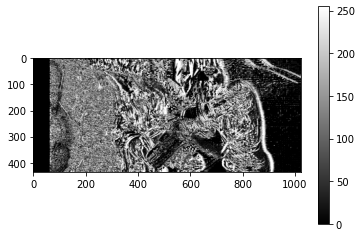

1.42516 sec


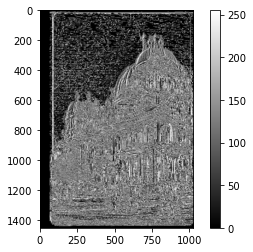

5.25694 sec


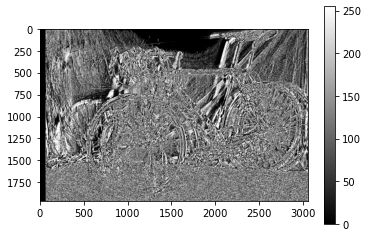

20.82733 sec


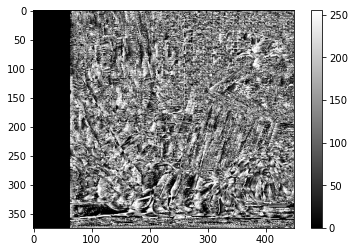

0.63427 sec


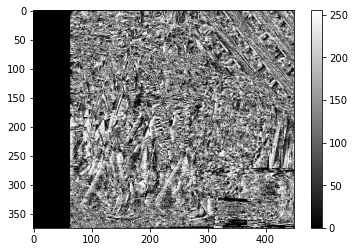

0.70614 sec


In [205]:
for i in range(0,10,2) :
    start = time.time()
    Census_Transform(img[i], img[i+1], 17, 16*4)
    end = time.time()
    print(f"{end - start:.5f} sec")


### Semi Global Matching

In [225]:
import argparse
import sys
import time as t

import cv2
import numpy as np

class Direction:
    def __init__(self, direction=(0, 0), name='invalid'):
        """
        represent a cardinal direction in image coordinates (top left = (0, 0) and bottom right = (1, 1)).
        :param direction: (x, y) for cardinal direction.
        :param name: common name of said direction.
        """
        self.direction = direction
        self.name = name
        
# 8 defined directions for sgm
N = Direction(direction=(0, -1), name='north')
NE = Direction(direction=(1, -1), name='north-east')
E = Direction(direction=(1, 0), name='east')
SE = Direction(direction=(1, 1), name='south-east')
S = Direction(direction=(0, 1), name='south')
SW = Direction(direction=(-1, 1), name='south-west')
W = Direction(direction=(-1, 0), name='west')
NW = Direction(direction=(-1, -1), name='north-west')


class Paths:
    def __init__(self):
        """
        represent the relation between the directions.
        """
        self.paths = [N, NE, E, SE, S, SW, W, NW]
        self.size = len(self.paths)
        self.effective_paths = [(E,  W), (SE, NW), (S, N), (SW, NE)]
        
class Parameters:
    def __init__(self, max_disparity=64, P1=5, P2=70, csize=(7, 7), bsize=(3, 3)):
        self.max_disparity = max_disparity
        self.P1 = P1
        self.P2 = P2
        self.csize = csize
        self.bsize = bsize

def get_indices(offset, dim, direction, height):
    """
    for the diagonal directions (SE, SW, NW, NE), return the array of indices for the current slice.
    :param offset: difference with the main diagonal of the cost volume.
    :param dim: number of elements along the path.
    :param direction: current aggregation direction.
    :param height: H of the cost volume.
    :return: arrays for the y (H dimension) and x (W dimension) indices.
    """
    y_indices = []
    x_indices = []

    for i in range(0, dim):
        if direction == SE.direction:
            if offset < 0:
                y_indices.append(-offset + i)
                x_indices.append(0 + i)
            else:
                y_indices.append(0 + i)
                x_indices.append(offset + i)

        if direction == SW.direction:
            if offset < 0:
                y_indices.append(height + offset - i)
                x_indices.append(0 + i)
            else:
                y_indices.append(height - i)
                x_indices.append(offset + i)

    return np.array(y_indices), np.array(x_indices)

        
def get_path_cost(slice, offset, parameters):
    """
    part of the aggregation step, finds the minimum costs in a D x M slice (where M = the number of pixels in the
    given direction)
    :param slice: M x D array from the cost volume.
    :param offset: ignore the pixels on the border.
    :param parameters: structure containing parameters of the algorithm.
    :return: M x D array of the minimum costs for a given slice in a given direction.
    """
    other_dim = slice.shape[0]
    disparity_dim = slice.shape[1]

    disparities = [d for d in range(disparity_dim)] * disparity_dim
    disparities = np.array(disparities).reshape(disparity_dim, disparity_dim)

    penalties = np.zeros(shape=(disparity_dim, disparity_dim), dtype=slice.dtype)
    penalties[np.abs(disparities - disparities.T) == 1] = parameters.P1
    penalties[np.abs(disparities - disparities.T) > 1] = parameters.P2

    minimum_cost_path = np.zeros(shape=(other_dim, disparity_dim), dtype=slice.dtype)
    minimum_cost_path[offset - 1, :] = slice[offset - 1, :]

    for i in range(offset, other_dim):
        previous_cost = minimum_cost_path[i - 1, :]
        current_cost = slice[i, :]
        costs = np.repeat(previous_cost, repeats=disparity_dim, axis=0).reshape(disparity_dim, disparity_dim)
        costs = np.amin(costs + penalties, axis=0)
        minimum_cost_path[i, :] = current_cost + costs - np.amin(previous_cost)
    return minimum_cost_path

        
def aggregate_costs(cost_volume, parameters, paths):
    height = cost_volume.shape[0]
    width = cost_volume.shape[1]
    disparities = cost_volume.shape[2]
    start = -(height - 1)
    end = width - 1

    aggregation_volume = np.zeros(shape=(height, width, disparities, paths.size), dtype=cost_volume.dtype)

    path_id = 0
    for path in paths.effective_paths:
        print('\tProcessing paths {} and {}...'.format(path[0].name, path[1].name), end='')
        sys.stdout.flush()
        dawn = t.time()

        main_aggregation = np.zeros(shape=(height, width, disparities), dtype=cost_volume.dtype)
        opposite_aggregation = np.copy(main_aggregation)

        main = path[0]
        if main.direction == S.direction:
            for x in range(0, width):
                south = cost_volume[0:height, x, :]
                north = np.flip(south, axis=0)
                main_aggregation[:, x, :] = get_path_cost(south, 1, parameters)
                opposite_aggregation[:, x, :] = np.flip(get_path_cost(north, 1, parameters), axis=0)

        if main.direction == E.direction:
            for y in range(0, height):
                east = cost_volume[y, 0:width, :]
                west = np.flip(east, axis=0)
                main_aggregation[y, :, :] = get_path_cost(east, 1, parameters)
                opposite_aggregation[y, :, :] = np.flip(get_path_cost(west, 1, parameters), axis=0)

        if main.direction == SE.direction:
            for offset in range(start, end):
                south_east = cost_volume.diagonal(offset=offset).T
                north_west = np.flip(south_east, axis=0)
                dim = south_east.shape[0]
                y_se_idx, x_se_idx = get_indices(offset, dim, SE.direction, None)
                y_nw_idx = np.flip(y_se_idx, axis=0)
                x_nw_idx = np.flip(x_se_idx, axis=0)
                main_aggregation[y_se_idx, x_se_idx, :] = get_path_cost(south_east, 1, parameters)
                opposite_aggregation[y_nw_idx, x_nw_idx, :] = get_path_cost(north_west, 1, parameters)

        if main.direction == SW.direction:
            for offset in range(start, end):
                south_west = np.flipud(cost_volume).diagonal(offset=offset).T
                north_east = np.flip(south_west, axis=0)
                dim = south_west.shape[0]
                y_sw_idx, x_sw_idx = get_indices(offset, dim, SW.direction, height - 1)
                y_ne_idx = np.flip(y_sw_idx, axis=0)
                x_ne_idx = np.flip(x_sw_idx, axis=0)
                main_aggregation[y_sw_idx, x_sw_idx, :] = get_path_cost(south_west, 1, parameters)
                opposite_aggregation[y_ne_idx, x_ne_idx, :] = get_path_cost(north_east, 1, parameters)

        aggregation_volume[:, :, :, path_id] = main_aggregation
        aggregation_volume[:, :, :, path_id + 1] = opposite_aggregation
        path_id = path_id + 2

        dusk = t.time()
        print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return aggregation_volume


def compute_costs(left, right, parameters):
    assert left.shape[0] == right.shape[0] and left.shape[1] == right.shape[1], 'left & right must have the same shape.'
    assert parameters.max_disparity > 0, 'maximum disparity must be greater than 0.'

    height = left.shape[0]
    width = left.shape[1]
    cheight = parameters.csize[0]
    cwidth = parameters.csize[1]
    y_offset = int(cheight / 2)
    x_offset = int(cwidth / 2)
    disparity = parameters.max_disparity

    left_img_census = np.zeros(shape=(height, width), dtype=np.uint8)
    right_img_census = np.zeros(shape=(height, width), dtype=np.uint8)
    left_census_values = np.zeros(shape=(height, width), dtype=np.uint64)
    right_census_values = np.zeros(shape=(height, width), dtype=np.uint64)

    print('\tComputing left and right census...', end='')
    sys.stdout.flush()
    dawn = t.time()
    # pixels on the border will have no census values
    for y in range(y_offset, height - y_offset):
        for x in range(x_offset, width - x_offset):
            left_census = np.int64(0)
            center_pixel = left[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int64)
            image = left[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            for j in range(comparison.shape[0]):
                for i in range(comparison.shape[1]):
                    if (i, j) != (y_offset, x_offset):
                        left_census = left_census << 1
                        if comparison[j, i] < 0:
                            bit = 1
                        else:
                            bit = 0
                        left_census = left_census | bit
            left_img_census[y, x] = np.uint8(left_census)
            left_census_values[y, x] = left_census

            right_census = np.int64(0)
            center_pixel = right[y, x]
            reference = np.full(shape=(cheight, cwidth), fill_value=center_pixel, dtype=np.int64)
            image = right[(y - y_offset):(y + y_offset + 1), (x - x_offset):(x + x_offset + 1)]
            comparison = image - reference
            for j in range(comparison.shape[0]):
                for i in range(comparison.shape[1]):
                    if (i, j) != (y_offset, x_offset):
                        right_census = right_census << 1
                        if comparison[j, i] < 0:
                            bit = 1
                        else:
                            bit = 0
                        right_census = right_census | bit
            right_img_census[y, x] = np.uint8(right_census)
            right_census_values[y, x] = right_census

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))



    print('\tComputing cost volumes...', end='')
    sys.stdout.flush()
    dawn = t.time()
    left_cost_volume = np.zeros(shape=(height, width, disparity), dtype=np.uint32)
    right_cost_volume = np.zeros(shape=(height, width, disparity), dtype=np.uint32)
    lcensus = np.zeros(shape=(height, width), dtype=np.int64)
    rcensus = np.zeros(shape=(height, width), dtype=np.int64)
    for d in range(0, disparity):
        rcensus[:, (x_offset + d):(width - x_offset)] = right_census_values[:, x_offset:(width - d - x_offset)]
        left_xor = np.int64(np.bitwise_xor(np.int64(left_census_values), rcensus))
        left_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(left_xor == 0):
            tmp = left_xor - 1
            mask = left_xor != 0
            left_xor[mask] = np.bitwise_and(left_xor[mask], tmp[mask])
            left_distance[mask] = left_distance[mask] + 1
        left_cost_volume[:, :, d] = left_distance

        lcensus[:, x_offset:(width - d - x_offset)] = left_census_values[:, (x_offset + d):(width - x_offset)]
        right_xor = np.int64(np.bitwise_xor(np.int64(right_census_values), lcensus))
        right_distance = np.zeros(shape=(height, width), dtype=np.uint32)
        while not np.all(right_xor == 0):
            tmp = right_xor - 1
            mask = right_xor != 0
            right_xor[mask] = np.bitwise_and(right_xor[mask], tmp[mask])
            right_distance[mask] = right_distance[mask] + 1
        right_cost_volume[:, :, d] = right_distance

    dusk = t.time()
    print('\t(done in {:.2f}s)'.format(dusk - dawn))

    return left_cost_volume, right_cost_volume


def select_disparity(aggregation_volume):
    volume = np.sum(aggregation_volume, axis=3)
    disparity_map = np.argmin(volume, axis=2)
    return disparity_map


def normalize(volume, parameters):
    return 255.0 * volume / parameters.max_disparity


def get_recall(disparity, gt, args):
    gt = np.float32(cv2.imread(gt, cv2.IMREAD_GRAYSCALE))
    gt = np.int16(gt / 255.0 * float(args.disp))
    disparity = np.int16(np.float32(disparity) / 255.0 * float(args.disp))
    correct = np.count_nonzero(np.abs(disparity - gt) <= 3)
    return float(correct) / gt.size

In [226]:
def SGM(left, right, papram):
    paths = Paths()
    left_cost_volume, right_cost_volume = compute_costs(left, right, parameters)

    print('\nStarting left aggregation computation...')
    left_aggregation_volume = aggregate_costs(left_cost_volume, parameters, paths)
    print('\nStarting right aggregation computation...')
    right_aggregation_volume = aggregate_costs(right_cost_volume, parameters, paths)

    print('\nSelecting best disparities...')
    left_disparity_map = np.uint8(normalize(select_disparity(left_aggregation_volume), parameters))
    right_disparity_map = np.uint8(normalize(select_disparity(right_aggregation_volume), parameters))

    print('\nApplying median filter...')
    left_disparity_map = cv2.medianBlur(left_disparity_map, parameters.bsize[0])
    
    plt.imshow(left_disparity_map, 'gray') ## 'costs'
    plt.colorbar()
    plt.show()

	Computing left and right census...	(done in 62.09s)
	Computing cost volumes...	(done in 49.60s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 35.53s)
	Processing paths south-east and north-west...	(done in 31.23s)
	Processing paths south and north...	(done in 31.87s)
	Processing paths south-west and north-east...	(done in 31.45s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 29.95s)
	Processing paths south-east and north-west...	(done in 30.34s)
	Processing paths south and north...	(done in 29.24s)
	Processing paths south-west and north-east...	(done in 30.06s)

Selecting best disparities...

Applying median filter...


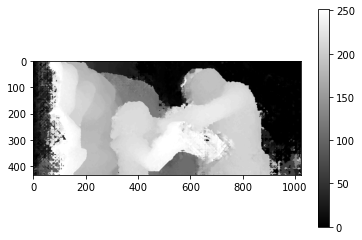

362.61649 sec
	Computing left and right census...	(done in 198.73s)
	Computing cost volumes...	(done in 177.46s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 99.10s)
	Processing paths south-east and north-west...	(done in 99.24s)
	Processing paths south and north...	(done in 94.66s)
	Processing paths south-west and north-east...	(done in 96.79s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 98.83s)
	Processing paths south-east and north-west...	(done in 98.41s)
	Processing paths south and north...	(done in 98.77s)
	Processing paths south-west and north-east...	(done in 100.79s)

Selecting best disparities...

Applying median filter...


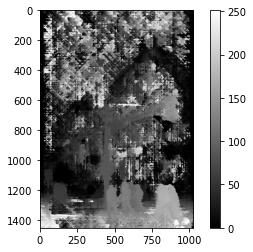

1167.22926 sec
	Computing left and right census...

KeyboardInterrupt: 

In [228]:
parameters = Parameters(max_disparity=64, P1=10, P2=120, csize=(7, 7), bsize=(3, 3))

for i in range(0,10,2) :
    start = time.time()
    SGM(img[i], img[i+1], parameters)
    end = time.time()
    print(f"{end - start:.5f} sec")


	Computing left and right census...	(done in 21.51s)
	Computing cost volumes...	(done in 18.84s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 11.25s)
	Processing paths south-east and north-west...	(done in 11.81s)
	Processing paths south and north...	(done in 11.38s)
	Processing paths south-west and north-east...	(done in 11.71s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 11.82s)
	Processing paths south-east and north-west...	(done in 11.46s)
	Processing paths south and north...	(done in 11.17s)
	Processing paths south-west and north-east...	(done in 11.54s)

Selecting best disparities...

Applying median filter...


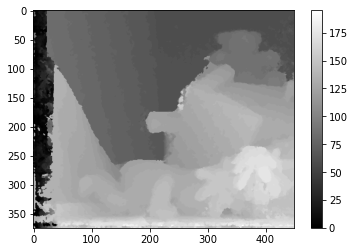

133.16107 sec
	Computing left and right census...	(done in 21.36s)
	Computing cost volumes...	(done in 17.63s)

Starting left aggregation computation...
	Processing paths east and west...	(done in 11.09s)
	Processing paths south-east and north-west...	(done in 11.78s)
	Processing paths south and north...	(done in 11.87s)
	Processing paths south-west and north-east...	(done in 12.61s)

Starting right aggregation computation...
	Processing paths east and west...	(done in 11.15s)
	Processing paths south-east and north-west...	(done in 11.71s)
	Processing paths south and north...	(done in 11.10s)
	Processing paths south-west and north-east...	(done in 11.81s)

Selecting best disparities...

Applying median filter...


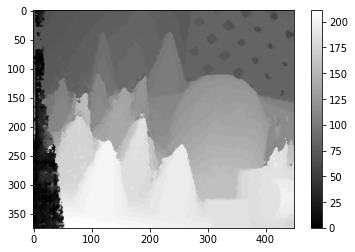

132.69102 sec


In [236]:
for i in range(6,10,2) :
    start = time.time()
    SGM(img[i], img[i+1], parameters)
    end = time.time()
    print(f"{end - start:.5f} sec")